# Models – Predicting Student Performance Using Machine Learning

This notebook focuses on implementing machine learning regression models to predict student academic performance based on various features such as moodle or caronte activity, past grades, participation, and other contextual factors. By anticipating students' future marks, this system aims to identify at-risk individuals early and send alerts to enable timely intervention and support.

The ultimate goal of this predictive approach is to enhance student outcomes by allowing educators and support systems to take data-driven, proactive actions rather than reactive ones.

### Objectives:

- Build and evaluate multiple regression models (e.g., Linear Regression, Random Forest, Gradient Boosting, ..).

- Select the best-performing model for prediction.

- Provide predicted marks for individual students.

- Enable early warning systems based on risk thresholds.

### First we import and split data into train (historical) and test (2023/24)

DO NOT include any 2023/24 data in training. Including 2023/24 in training would leak future information into the model.

In [1]:
!pip install joblib

In [2]:
import joblib 

In [3]:
from DATASET import clean_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = clean_df.copy()
df = df.dropna(subset=['nota_assignatura'])

# Separate current year data (to predict)
df_train = df[df['curs_academic'] != '2023/24'].copy()
df_pred_target = df[df['curs_academic'] == '2023/24'].copy()

                              Estudi Curs acadèmic  \
0  Graduat en Enginyeria Informàtica       2020/21   
1  Graduat en Enginyeria Informàtica       2020/21   
2  Graduat en Enginyeria Informàtica       2020/21   
3  Graduat en Enginyeria Informàtica       2020/21   
4  Graduat en Enginyeria Informàtica       2020/21   

                          Id Anonim  Sexe                 Assignatura  \
0  1DFB71F2B000D1421808D0B3F67B335E  Home                     Àlgebra   
1  1DFB71F2B000D1421808D0B3F67B335E  Home                      Càlcul   
2  1DFB71F2B000D1421808D0B3F67B335E  Home  Electricitat i Electrònica   
3  1DFB71F2B000D1421808D0B3F67B335E  Home      Fonaments d'Enginyeria   
4  1DFB71F2B000D1421808D0B3F67B335E  Home     Fonaments d'Informàtica   

   Codi assignatura  Nota_assignatura Curs acadèmic accés estudi  \
0            103801               0.0                    2020/21   
1            103802               0.0                    2020/21   
2            102771             

### Then we will prepare the features



In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Define target variable (Nota_assignatura) and input features (droping target from features)
X_train = df_train.drop(columns=['nota_assignatura'])
y_train = df_train['nota_assignatura']

X_pred = df_pred_target.drop(columns=['nota_assignatura'])
y_pred = df_pred_target['nota_assignatura']   # Ground truth for 2023/24

# Select categorical columns to encode
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keep non-categorical columns
)


### Evaluating model functions
Here we decide what are going to be the models evaluation so that we then compare it. 

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# This dictionary stores all different models evaluation results
allmodels_evaluation_results = {}

def evaluate_model(model_name, model, X_pred, y_pred, df_pred_target, prediction_column):
    """
    Function to evaluate a model based on its predictions and ground truth for the 2023/24 dataset.

    Parameters:
    model_name (str): The name of the model (e.g., 'Linear Regression', 'Polynomial Regression', 'Random Forest')
    model (sklearn model): The trained model (e.g., lr_model, poly_model, rf_model)
    X_pred (DataFrame): The feature data for predictions (2023/24 dataset)
    y_pred (Series): The ground truth for 2023/24
    df_pred_target (DataFrame): The dataframe containing the predicted grades
    prediction_column (str): The column name containing the model's predictions (e.g., 'predicted_nota_assignatura_lr')

    Returns:
    None
    """
    
    if not y_pred.isna().all():
        mse = mean_squared_error(y_pred, df_pred_target[prediction_column])
        r2 = model.score(X_pred, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_pred, df_pred_target[prediction_column])

        # Storing the evaluation metrics in the dictionary
        allmodels_evaluation_results[model_name] = {
            "R² Score": r2,
            "Mean Absolute Error (MAE)": mae,
            "Mean Squared Error (MSE)": mse,
            "Root Mean Squared Error (RMSE)": rmse
        }

        print(f"{model_name} - R² Score on 2023/24 prediction set: {r2:.2f}")
        print(f"{model_name} - Mean Absolute Error (MAE): {mae:.2f}")
        print(f"{model_name} - Mean Squared Error for 2023/24 predictions: {mse:.2f}")
        print(f"{model_name} - Root Mean Squared Error (RMSE): {rmse:.2f}")


### Plotting functions 
Deciding the plotting of each model results. 

In [6]:
# Get unique study programs (estudi)
unique_studies = df_pred_target['estudi'].unique()

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predicted_vs_actual(df_pred_target, prediction_column, model_name, unique_studies):
    """
    Function to plot Predicted vs Actual Grades iteratively for each study program.

    Parameters:
    df_pred_target (DataFrame): Dataframe containing the actual and predicted grades
    prediction_column (str): The column name containing the model's predictions (e.g., 'predicted_nota_assignatura_lr', 'predicted_nota_assignatura_poly', etc.)
    model_name (str): The name of the model (e.g., 'Linear Regression', 'Polynomial Regression', 'Random Forest')
    unique_studies (array-like): The unique study programs to iterate over

    Returns:
    None
    """
    for study in unique_studies:
        df_study = df_pred_target[df_pred_target['estudi'] == study]

        if df_study[['nota_assignatura', prediction_column]].isna().all().any():
            continue
        
        plt.figure(figsize=(8,6))
        sns.scatterplot(x='nota_assignatura', y=prediction_column, data=df_study)
        plt.plot([0, 10], [0, 10], color='red', linestyle='--', label='Ideal prediction (y = x)')
        plt.xlabel('Actual Grade')
        plt.ylabel('Predicted Grade')
        plt.title(f'Predicted vs Actual Grades ({model_name}) \n {study} - {model_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [8]:
def plot_residuals(df_pred_target, prediction_column, model_name, unique_studies):
    """
    Function to plot the Residual Distribution (Error Distribution) iteratively for each study program.

    Parameters:
    df_pred_target (DataFrame): Dataframe containing the actual and predicted grades
    prediction_column (str): The column name containing the model's predictions (e.g., 'predicted_nota_assignatura_lr', 'predicted_nota_assignatura_poly', etc.)
    model_name (str): The name of the model (e.g., 'Linear Regression', 'Polynomial Regression', 'Random Forest')
    unique_studies (array-like): The unique study programs to iterate over

    Returns:
    None
    """
    for study in unique_studies:
        df_study = df_pred_target[df_pred_target['estudi'] == study].copy()

        if df_study[['nota_assignatura', prediction_column]].isna().all().any():
            continue
        
        df_study.loc[:, 'residual'] = df_study['nota_assignatura'] - df_study[prediction_column]
        
        plt.figure(figsize=(8,6))
        sns.histplot(df_study['residual'], kde=True, bins=30, color='blue', label='Residuals Distribution')
        plt.axvline(0, color='red', linestyle='--', label='Zero Residual (Ideal Prediction)')
        plt.title(f'Residual Distribution (Actual - Predicted) - \n {study} ({model_name})', fontsize=14)
        plt.xlabel('Residual (Actual - Predicted)', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [9]:
def plot_barplot_avg_grades(df_pred_target, prediction_column, model_name, unique_studies):
    """
    Function to plot the average predicted vs actual grades per subject iteratively for each study program.

    Parameters:
    df_pred_target (DataFrame): Dataframe containing the actual and predicted grades.
    prediction_column (str): The column name containing the model's predictions (e.g., 'predicted_nota_assignatura_lr', 'predicted_nota_assignatura_poly', etc.).
    model_name (str): The name of the model (e.g., 'Linear Regression', 'Polynomial Regression', 'Random Forest').
    unique_studies (array-like): The unique study programs to iterate over.

    Returns:
    None
    """
    for study in unique_studies:
        df_study = df_pred_target[df_pred_target['estudi'] == study]

        # Skip if no data or missing values
        if df_study[['nota_assignatura', prediction_column]].isna().all().any():
            continue

        # Group by subject and calculate averages
        avg_by_subject = df_study.groupby('assignatura')[['nota_assignatura', prediction_column]].mean().sort_values(by='nota_assignatura')

        # Plot
        plt.figure(figsize=(12,6))
        avg_by_subject.plot(kind='bar', figsize=(14,6))
        plt.title(f'Average Actual vs Predicted Grades by Subject\n({study}) - {model_name}')
        plt.ylabel('Grade')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

####### CREDITS RECONEGUTS? --------------------

# MODELS
In this section, we build various machine learning models to predict student grades. Each model is trained on past academic data and tested on the 2023/24 data. We evaluate their performance using metrics like R², MAE, and RMSE, and visualize their predictions through comparison plots, residuals, and subject-level averages. This helps us understand how well each model captures the patterns in student performance.

## 1. Linear Regression

**Linear Regression** is a simple model that finds a straight-line relationship between the input features and the target—in this case, student grades. It tries to draw the best-fitting line through the data.

We use it because it's fast, easy to understand, and gives a good baseline for how well we can predict grades using basic patterns in the data.

In [10]:
from sklearn.metrics import mean_squared_error

# 5. Build preprocessing and modeling pipeline
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 6. Train the model
lr_model.fit(X_train, y_train)

# Step 5: Evaluate the model using R-squared score
print("Model R-squared on train data:", lr_model.score(X_train, y_train))

# Make predictions for 2023/24 data
df_pred_target['predicted_nota_assignatura_lr'] = lr_model.predict(X_pred)

Model R-squared on train data: 0.5413333911439597


In [11]:
# Evaluating Linear Regression Model
evaluate_model(
    model_name='Linear Regression', 
    model=lr_model, 
    X_pred=X_pred, 
    y_pred=y_pred, 
    df_pred_target=df_pred_target, 
    prediction_column='predicted_nota_assignatura_lr'
)

Linear Regression - R² Score on 2023/24 prediction set: 0.10
Linear Regression - Mean Absolute Error (MAE): 1.95
Linear Regression - Mean Squared Error for 2023/24 predictions: 5.84
Linear Regression - Root Mean Squared Error (RMSE): 2.42


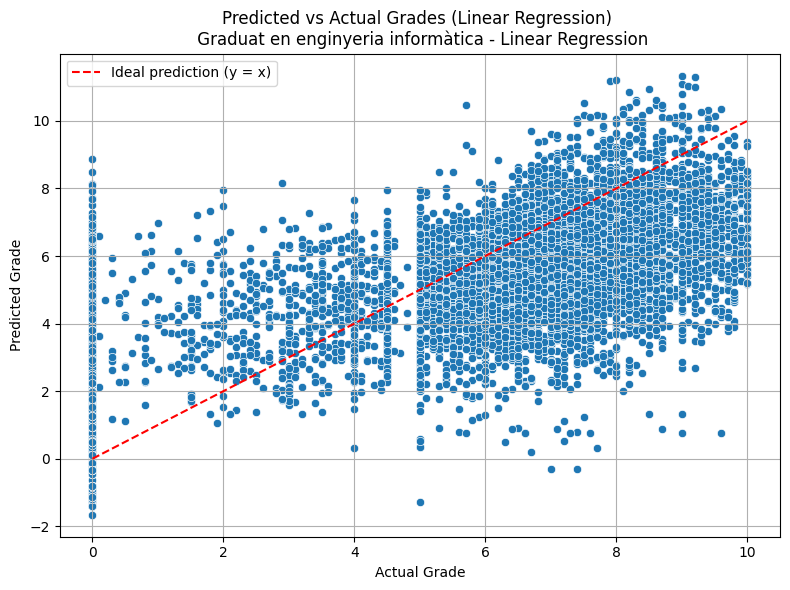

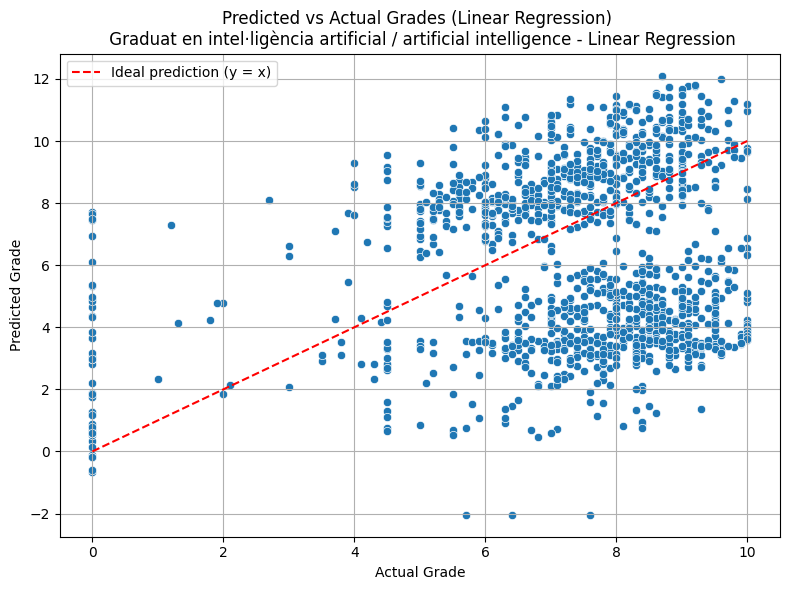

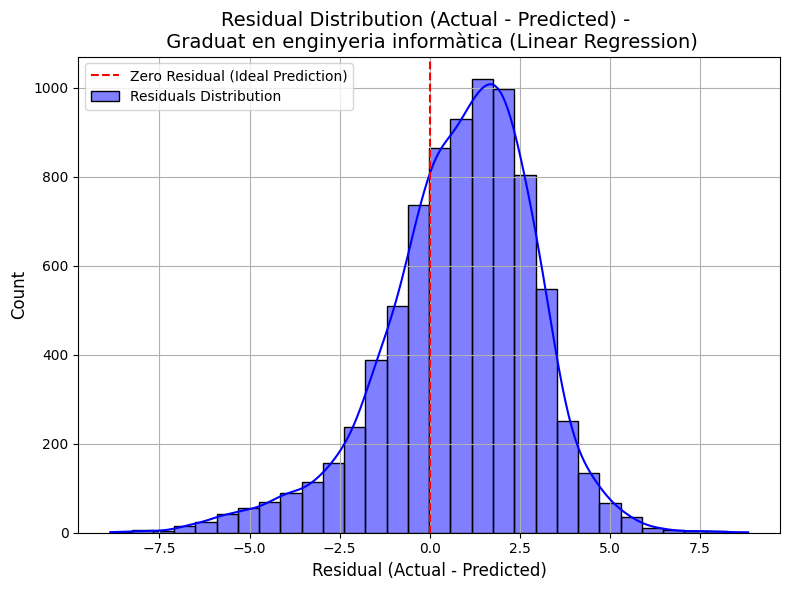

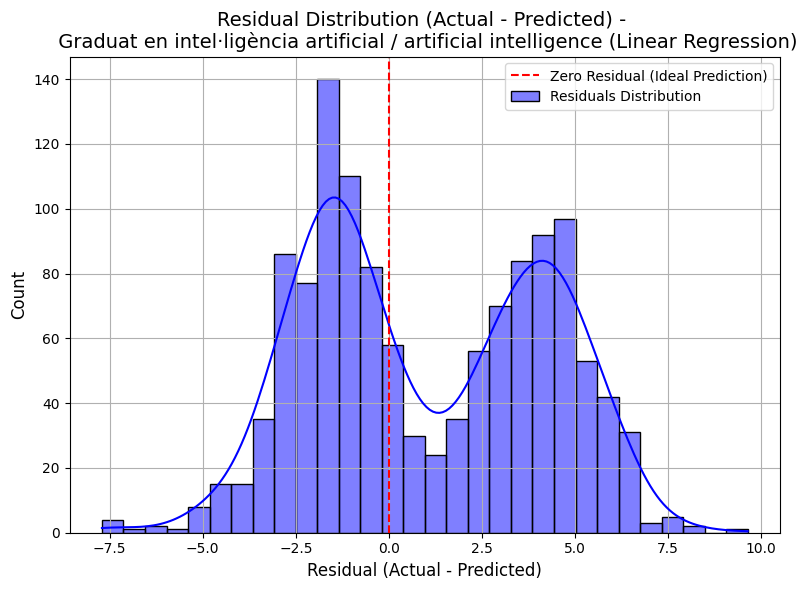

<Figure size 1200x600 with 0 Axes>

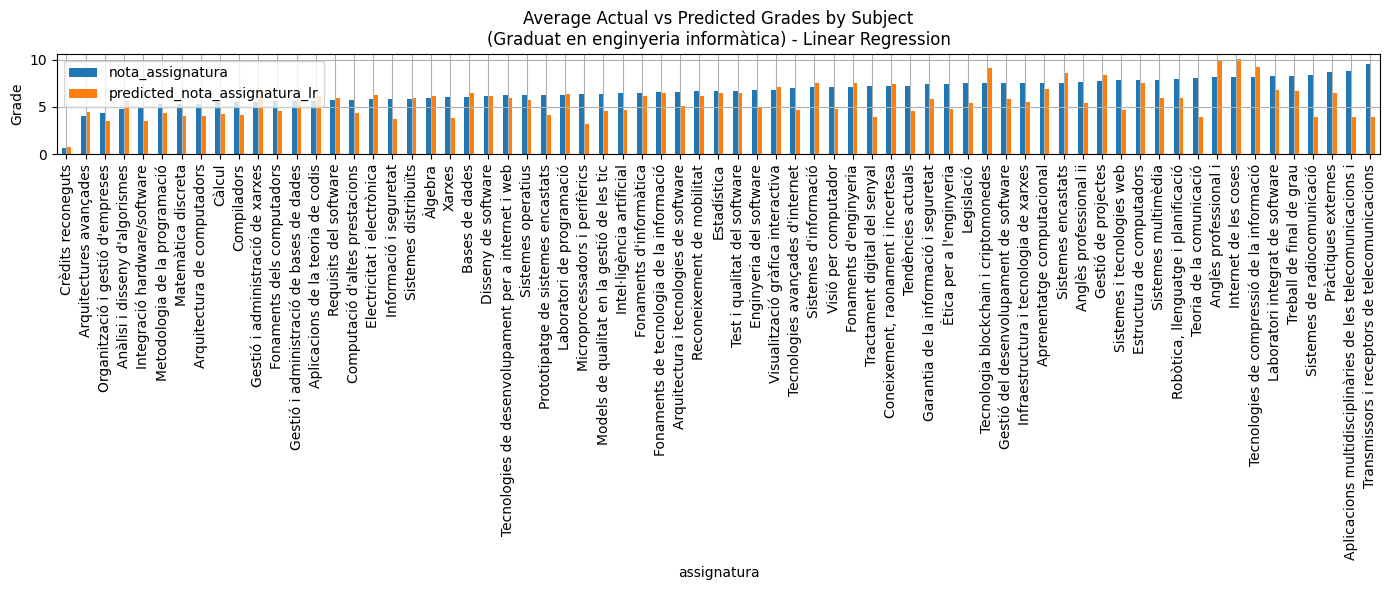

<Figure size 1200x600 with 0 Axes>

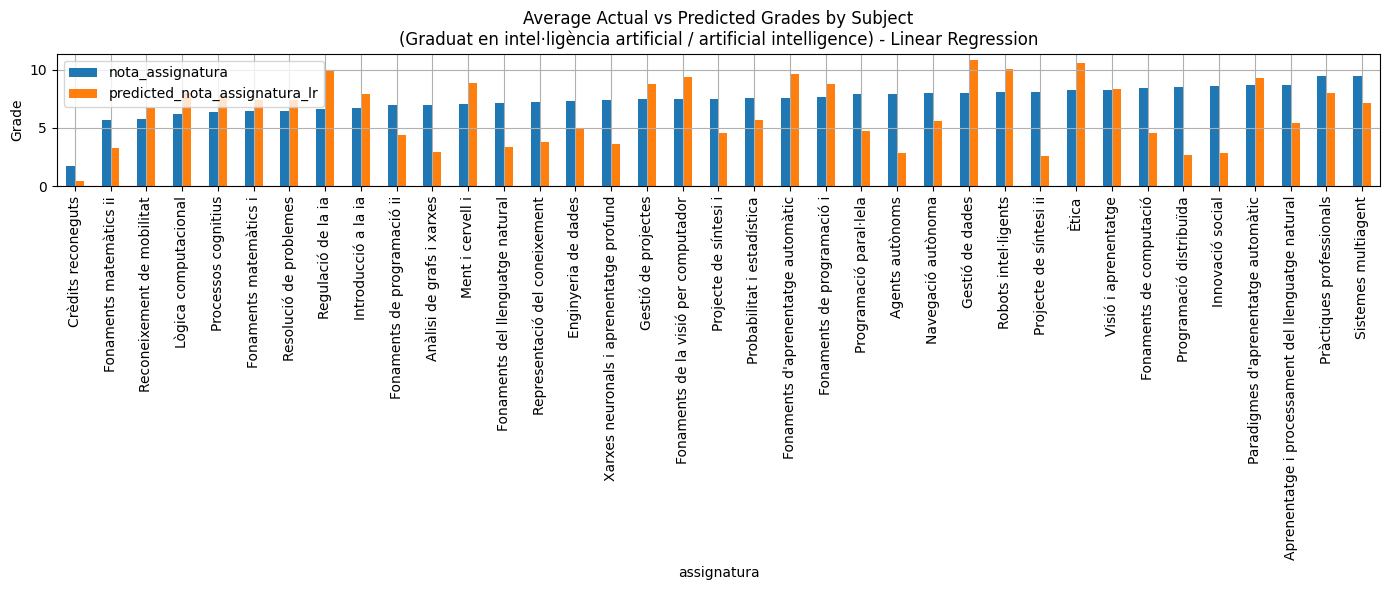

In [12]:
# Ploting Linear Regression predictions
plot_predicted_vs_actual(df_pred_target, 'predicted_nota_assignatura_lr', 'Linear Regression', unique_studies)
plot_residuals(df_pred_target, 'predicted_nota_assignatura_lr', 'Linear Regression', unique_studies)
plot_barplot_avg_grades(df_pred_target, 'predicted_nota_assignatura_lr', 'Linear Regression', unique_studies)


## 2. Polynomial Regression

**Polynomial Regression** is a method that extends simple linear regression by adding extra features based on powers (like squared terms) of the original ones. This allows the model to capture curves and more complex relationships in the data.

We use it to predict student grades because it can better fit patterns that aren't straight lines, giving the model more flexibility to match how different factors affect grades.

In [13]:
from sklearn.preprocessing import PolynomialFeatures
poly_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression())
])

# Train the polynomial regression model
poly_model.fit(X_train, y_train)

# Evaluate R-squared on training data
print("Polynomial Regression - Model R-squared on train data:", poly_model.score(X_train, y_train))

# Make predictions for 2023/24 data
df_pred_target['predicted_nota_assignatura_poly'] = poly_model.predict(X_pred)

# Make predictions for 2023/24 data
df_pred_target['predicted_nota_assignatura_poly'] = poly_model.predict(X_pred)


Polynomial Regression - Model R-squared on train data: 0.4907965290849229


In [14]:
# Evaluating Polynomial Regression
evaluate_model(
    model_name='Polynomial Regression', 
    model=poly_model, 
    X_pred=X_pred, 
    y_pred=y_pred, 
    df_pred_target=df_pred_target, 
    prediction_column='predicted_nota_assignatura_poly'
)

Polynomial Regression - R² Score on 2023/24 prediction set: 0.21
Polynomial Regression - Mean Absolute Error (MAE): 1.83
Polynomial Regression - Mean Squared Error for 2023/24 predictions: 5.15
Polynomial Regression - Root Mean Squared Error (RMSE): 2.27


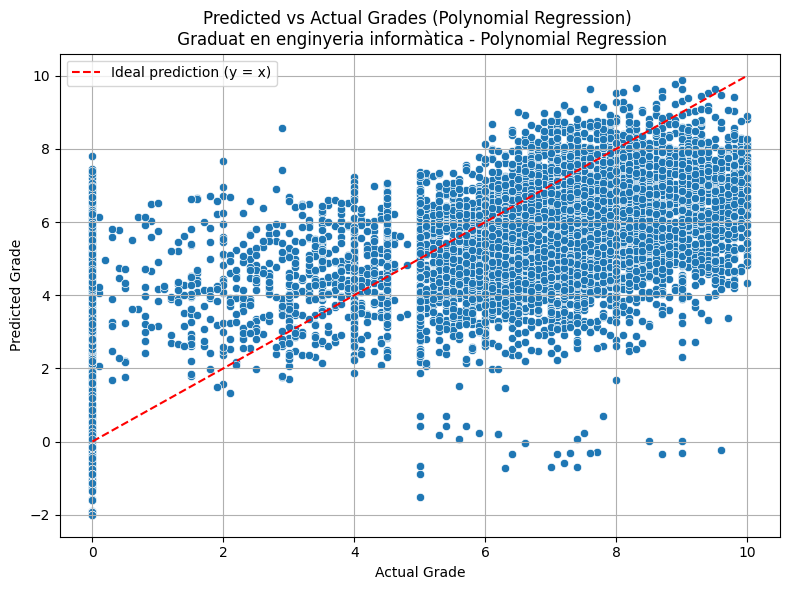

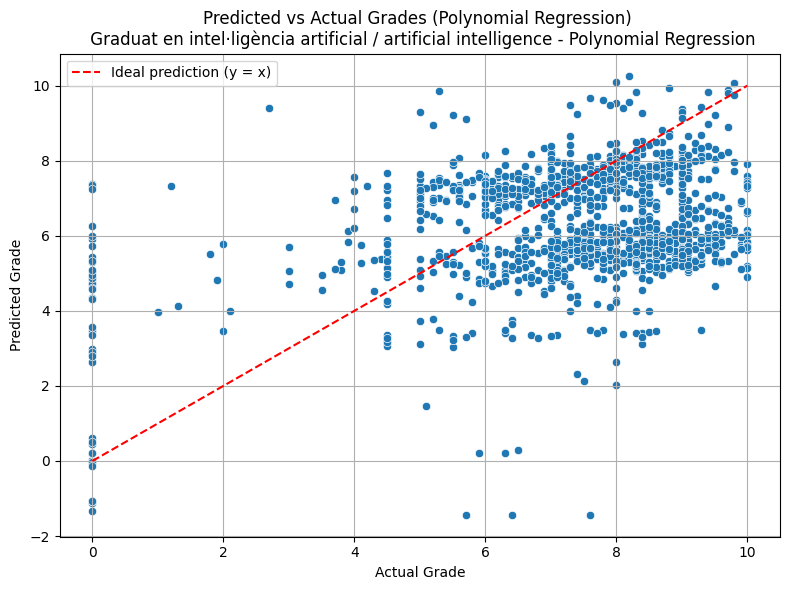

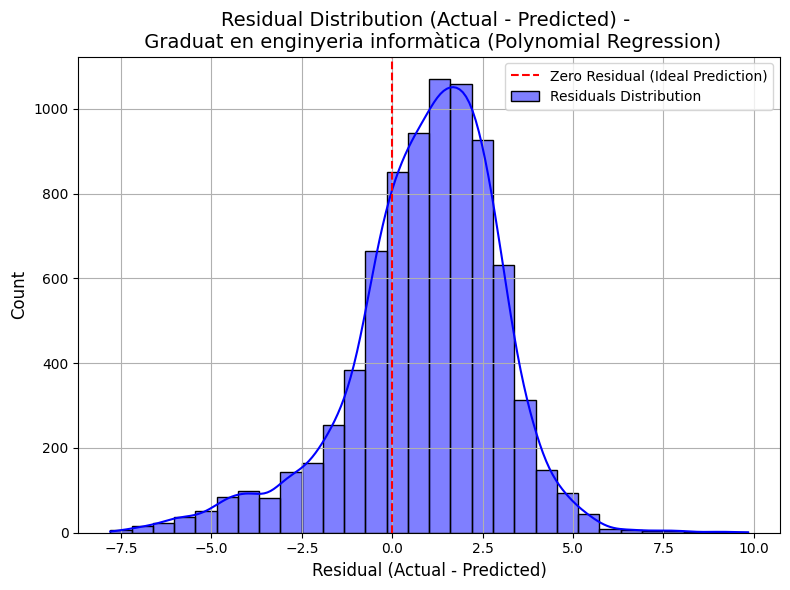

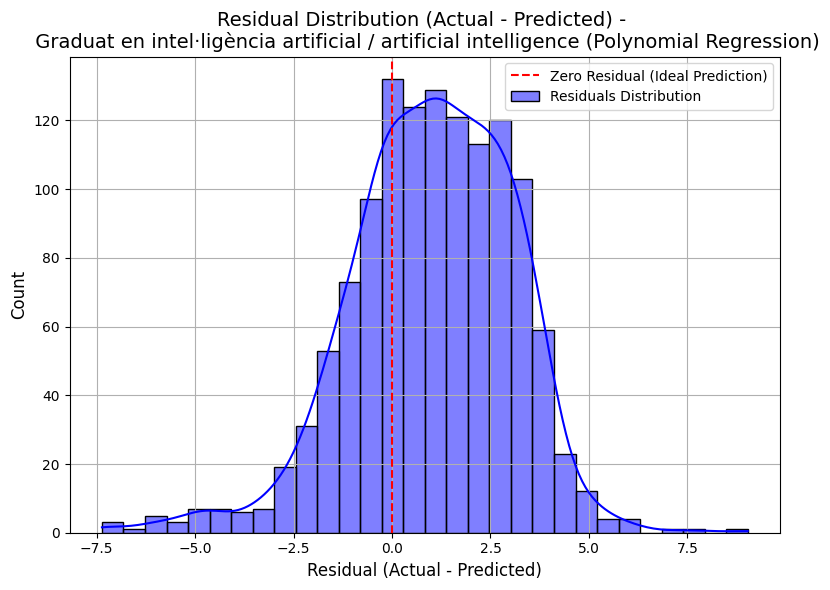

<Figure size 1200x600 with 0 Axes>

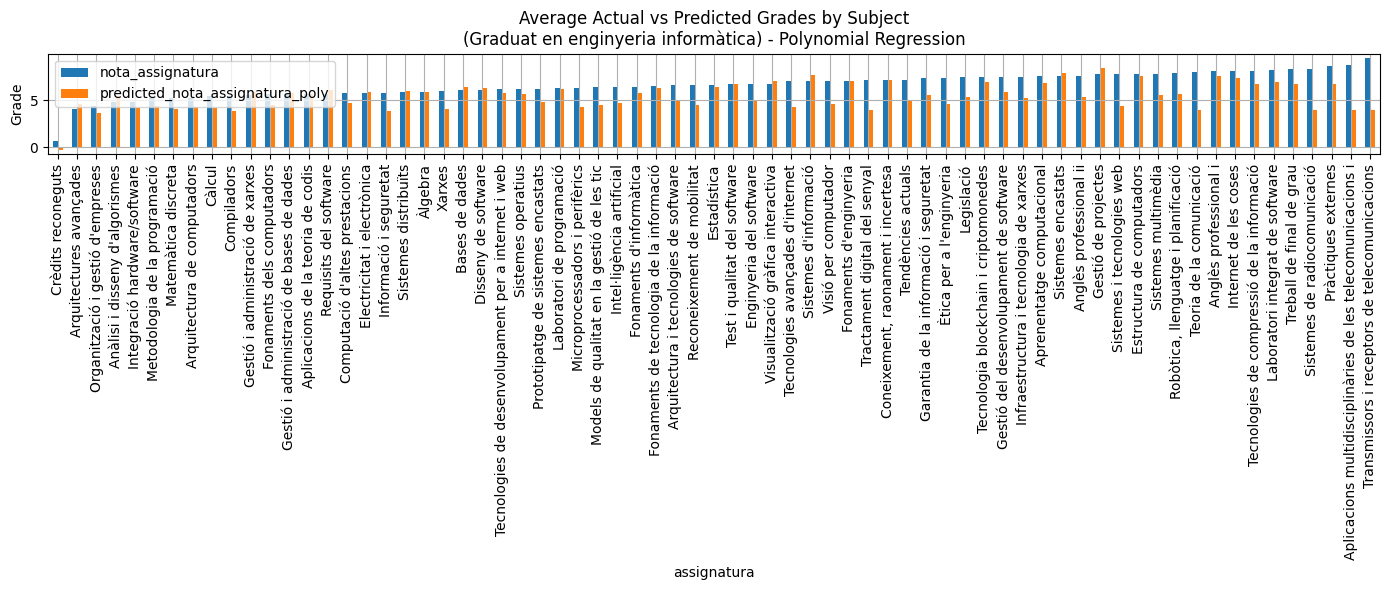

<Figure size 1200x600 with 0 Axes>

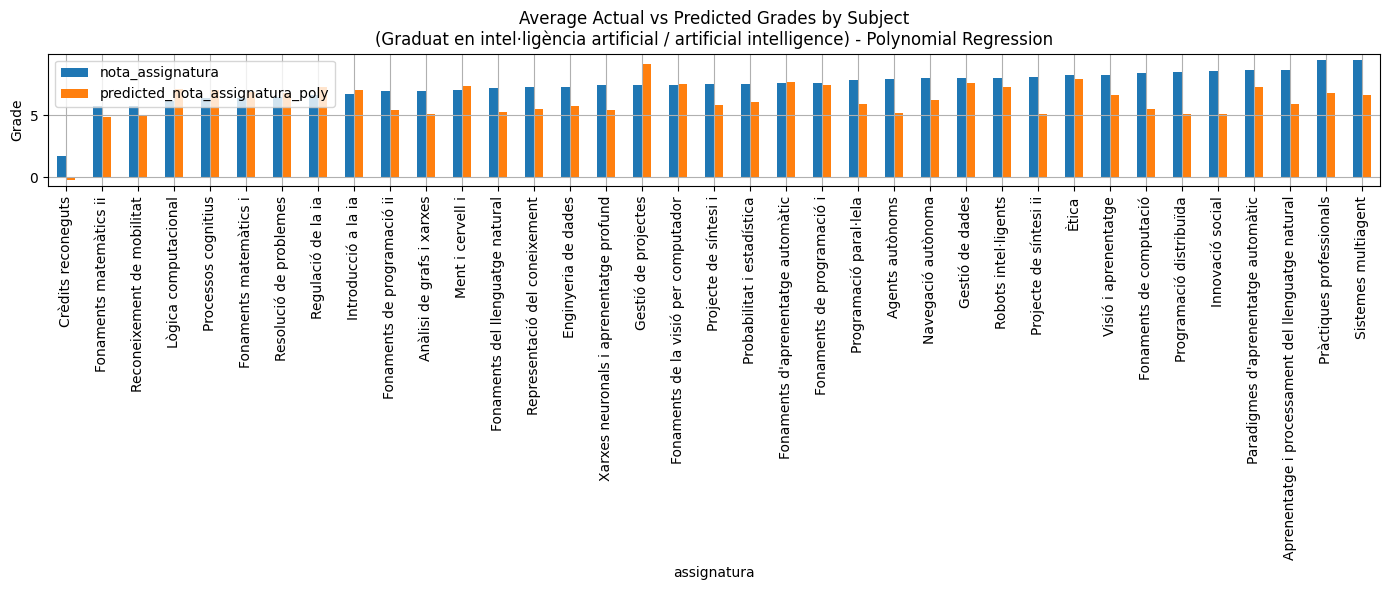

In [15]:
#Plotting Polynomial Regression predictions
plot_predicted_vs_actual(df_pred_target, 'predicted_nota_assignatura_poly', 'Polynomial Regression', unique_studies)
plot_residuals(df_pred_target, 'predicted_nota_assignatura_poly', 'Polynomial Regression', unique_studies)
plot_barplot_avg_grades(df_pred_target, 'predicted_nota_assignatura_poly', 'Polynomial Regression', unique_studies)


## 3. Random Forest

**Random Forest** is a method that uses many decision trees to make one final prediction. Each tree gives its own guess, and the model averages them to get a better result.

We use it to predict student grades because it handles lots of information well and gives more stable and accurate results than a single decision tree.

In [16]:
from sklearn.ensemble import RandomForestRegressor
# Random Forest Model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42))
])

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Evaluate R-squared on training data
print("Random Forest - Model R-squared on train data:", rf_model.score(X_train, y_train))

# Make predictions for 2023/24 data
df_pred_target['predicted_nota_assignatura_rf'] = rf_model.predict(X_pred)


Random Forest - Model R-squared on train data: 0.9581401583860424


In [17]:
# Evaluating Random Forest
evaluate_model(
    model_name='Random Forest', 
    model=rf_model, 
    X_pred=X_pred, 
    y_pred=y_pred, 
    df_pred_target=df_pred_target, 
    prediction_column='predicted_nota_assignatura_rf'
)

Random Forest - R² Score on 2023/24 prediction set: 0.41
Random Forest - Mean Absolute Error (MAE): 1.34
Random Forest - Mean Squared Error for 2023/24 predictions: 3.83
Random Forest - Root Mean Squared Error (RMSE): 1.96


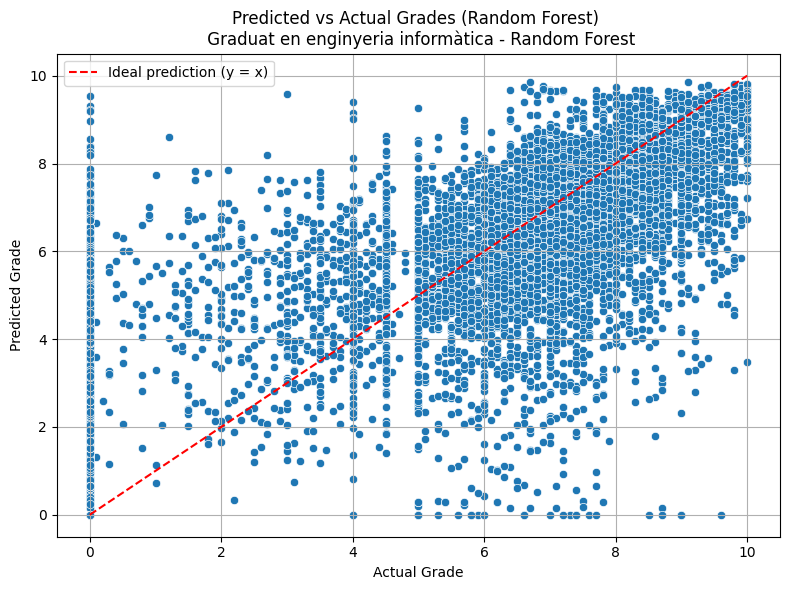

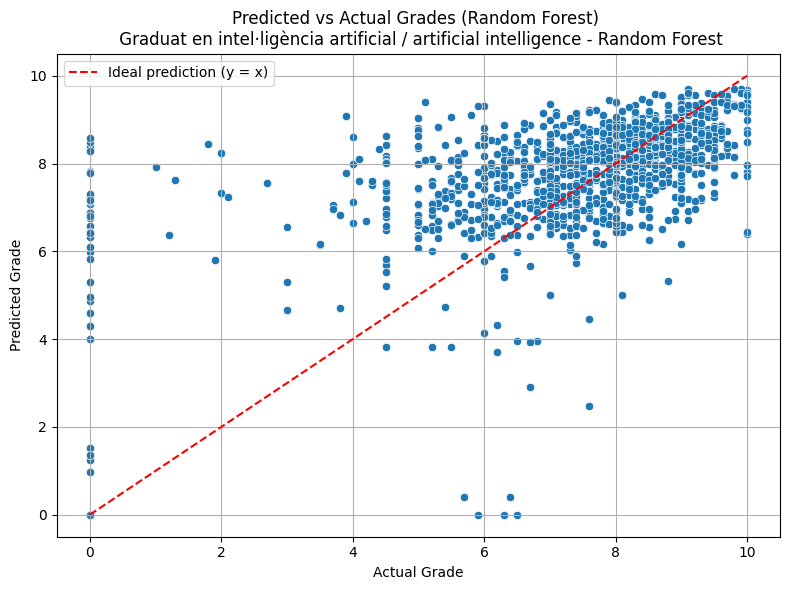

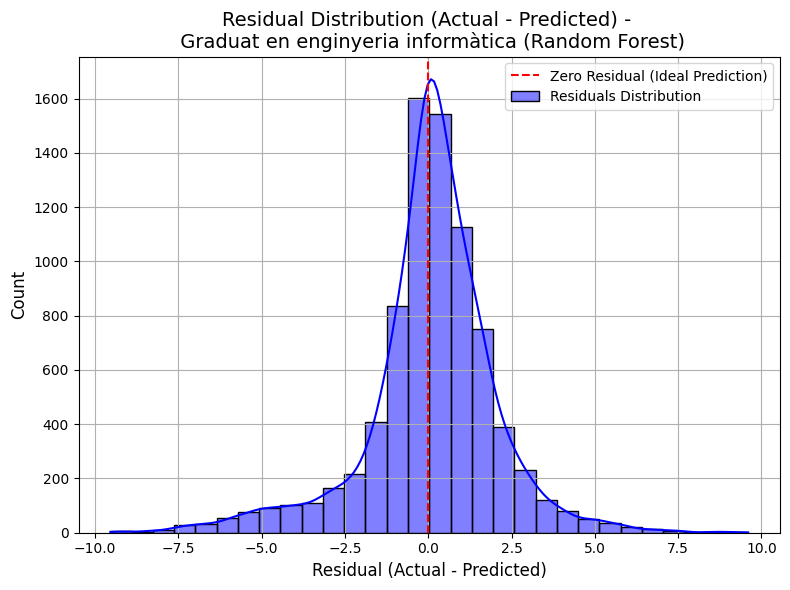

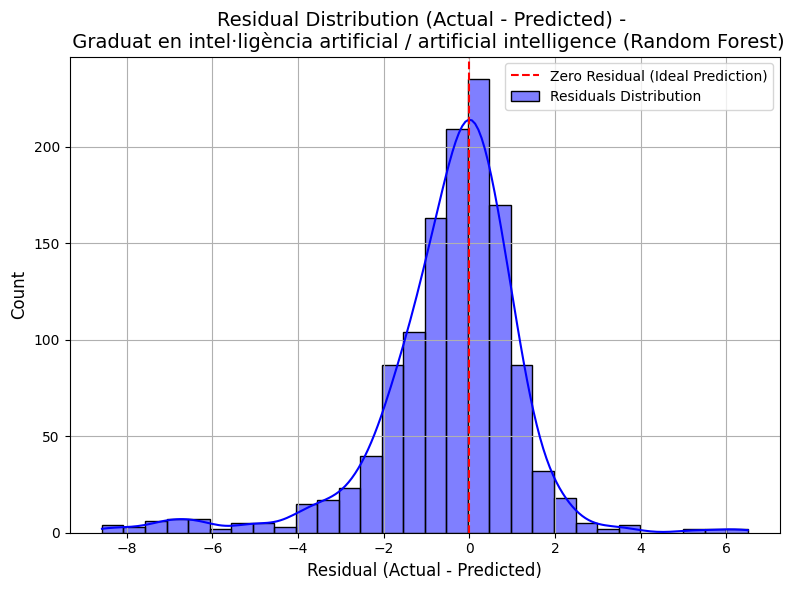

<Figure size 1200x600 with 0 Axes>

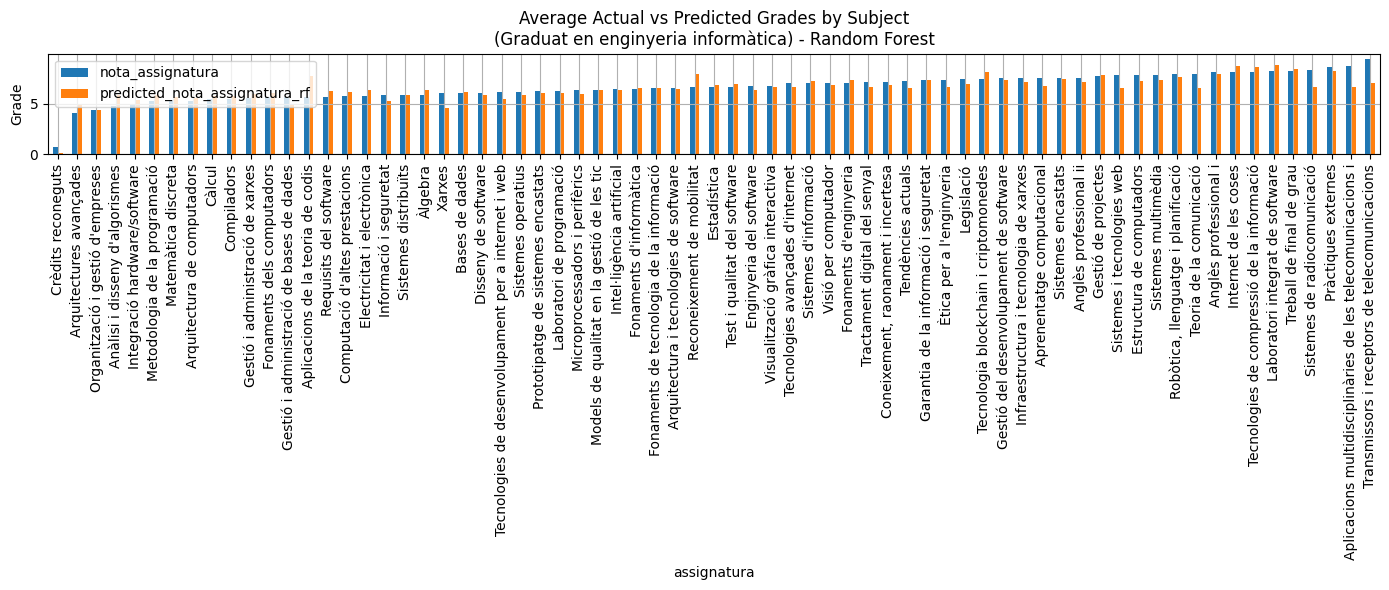

<Figure size 1200x600 with 0 Axes>

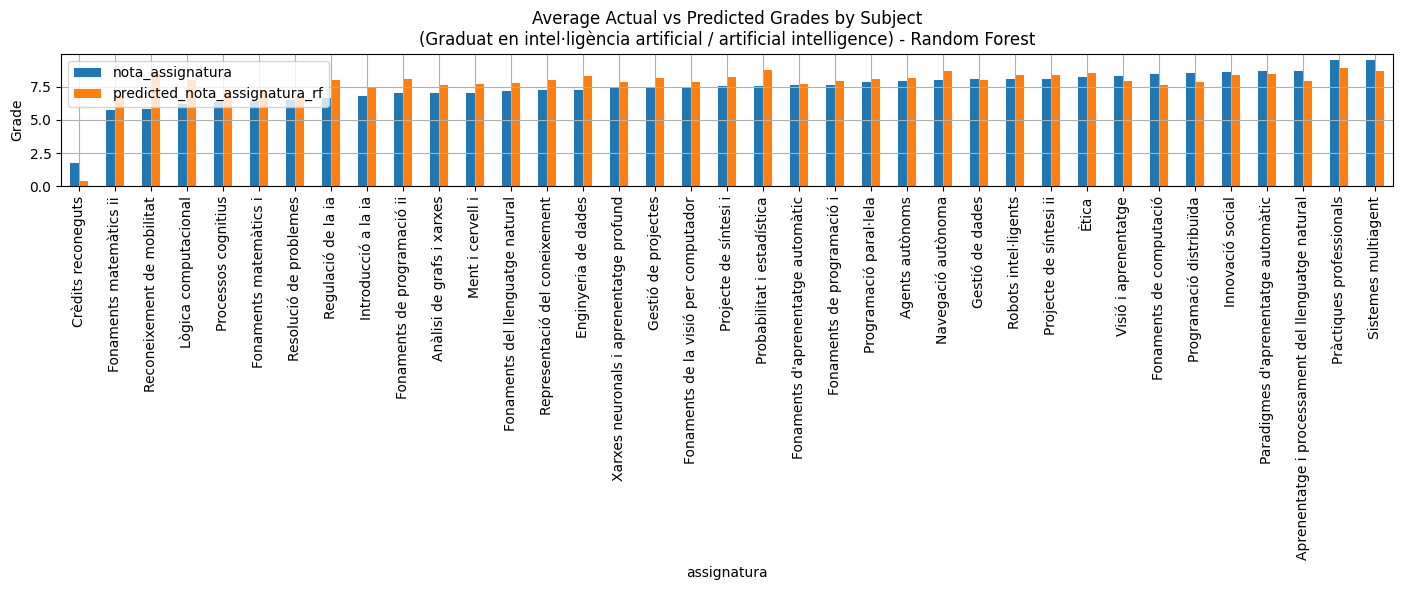

In [18]:
# Plotting Random Forest predictions
plot_predicted_vs_actual(df_pred_target, 'predicted_nota_assignatura_rf', 'Random Forest', unique_studies)
plot_residuals(df_pred_target, 'predicted_nota_assignatura_rf', 'Random Forest', unique_studies)
plot_barplot_avg_grades(df_pred_target, 'predicted_nota_assignatura_rf', 'Random Forest', unique_studies)

## 4. Gradient Boosting

**Gradient Boosting** is a machine learning technique that builds a model step by step by learning from its previous mistakes. It adds several simple decision trees one at a time, where each new tree tries to fix the errors made by the ones before.

In the context of predicting student grades, we use Gradient Boosting because it is good at handling complex patterns and interactions in the data. It gradually improves its predictions, making it a strong choice for capturing the different factors that affect student performance.

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

# Define Gradient Boosting pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Fit on training data
gb_pipeline.fit(X_train, y_train)

# Predict on 2023/24
df_pred_target['predicted_nota_assignatura_gb'] = gb_pipeline.predict(X_pred)

In [20]:
evaluate_model("Gradient Boosting", gb_pipeline, X_pred, y_pred, df_pred_target, "predicted_nota_assignatura_gb")

Gradient Boosting - R² Score on 2023/24 prediction set: 0.39
Gradient Boosting - Mean Absolute Error (MAE): 1.47
Gradient Boosting - Mean Squared Error for 2023/24 predictions: 3.94
Gradient Boosting - Root Mean Squared Error (RMSE): 1.99


---
The Gradient Boosting model achieved an **R² score of 0.36**, meaning it explains about 36% of the variance in student grades for the 2023/24 data. The **MAE of 1.59** and **RMSE of 2.09** suggest that, on average, the predicted grades deviate from the actual grades by around 1.6 to 2 points.

---

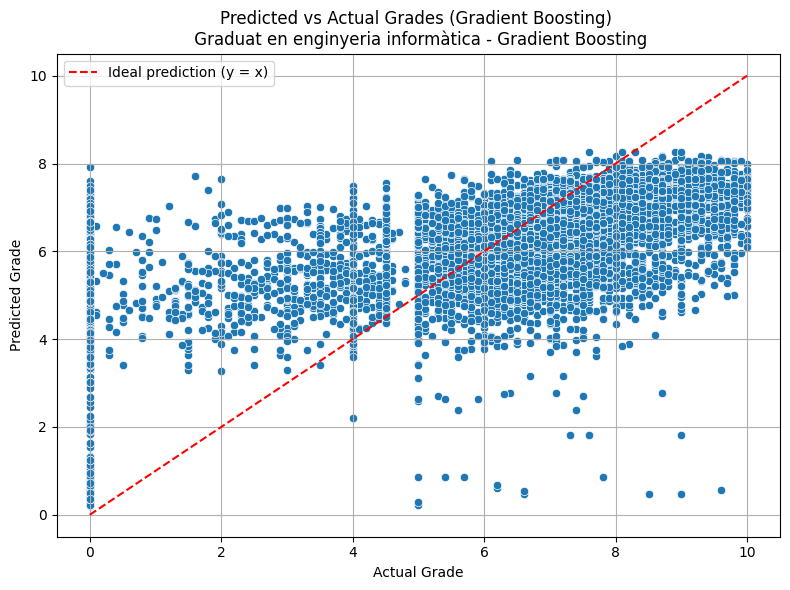

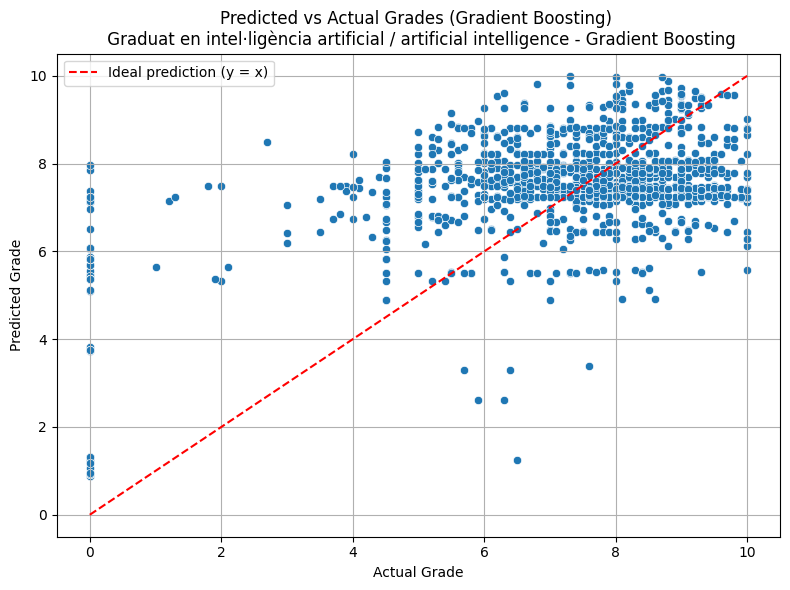

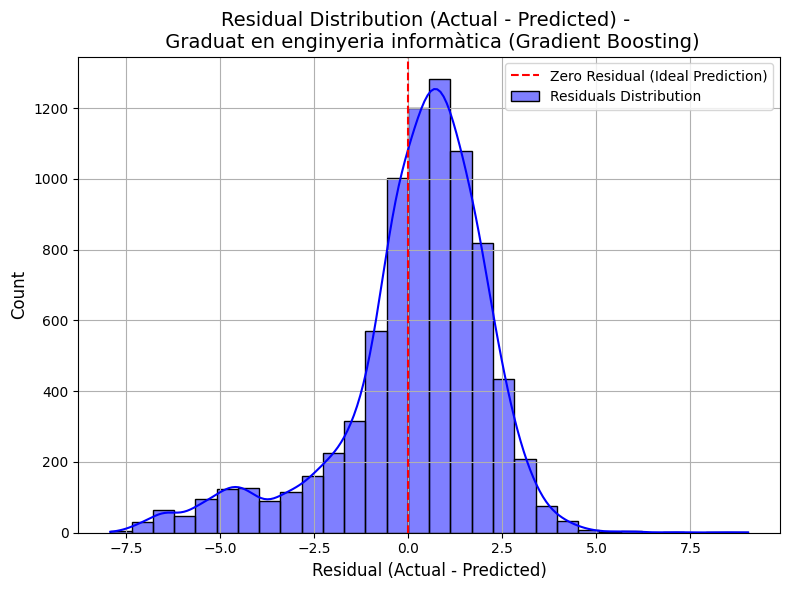

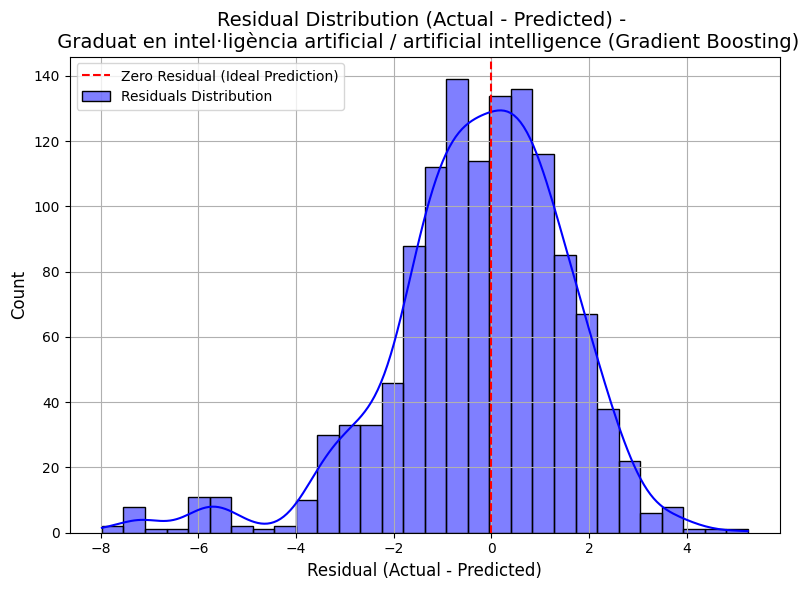

<Figure size 1200x600 with 0 Axes>

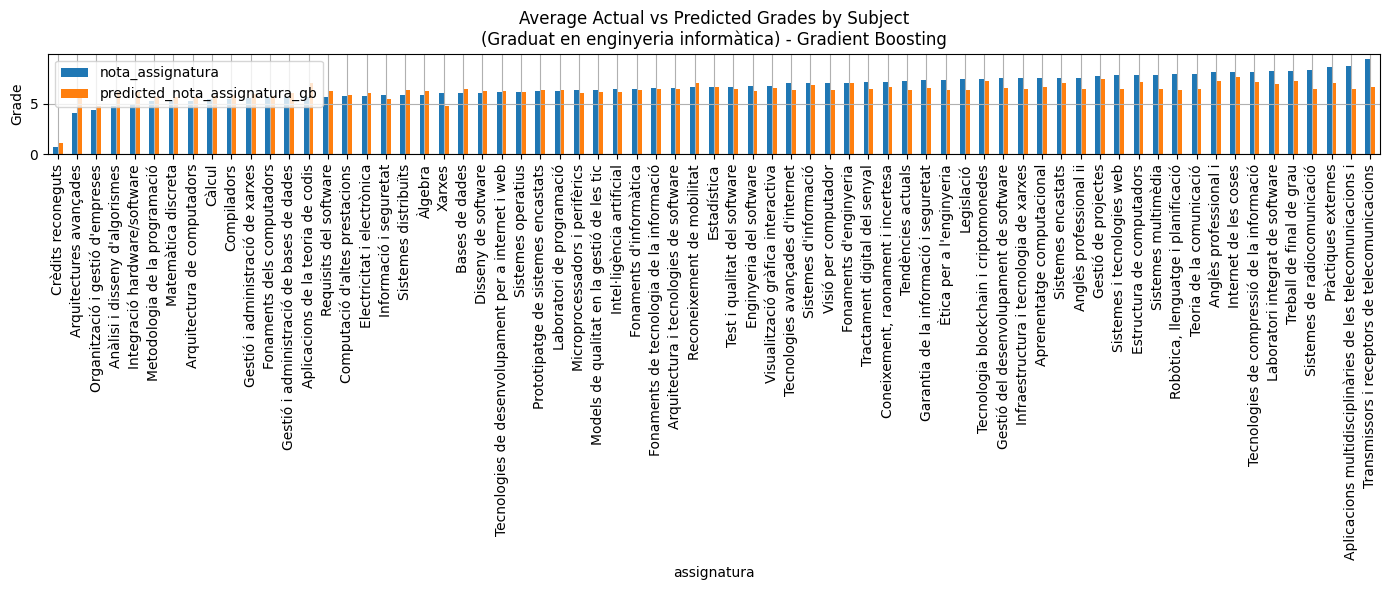

<Figure size 1200x600 with 0 Axes>

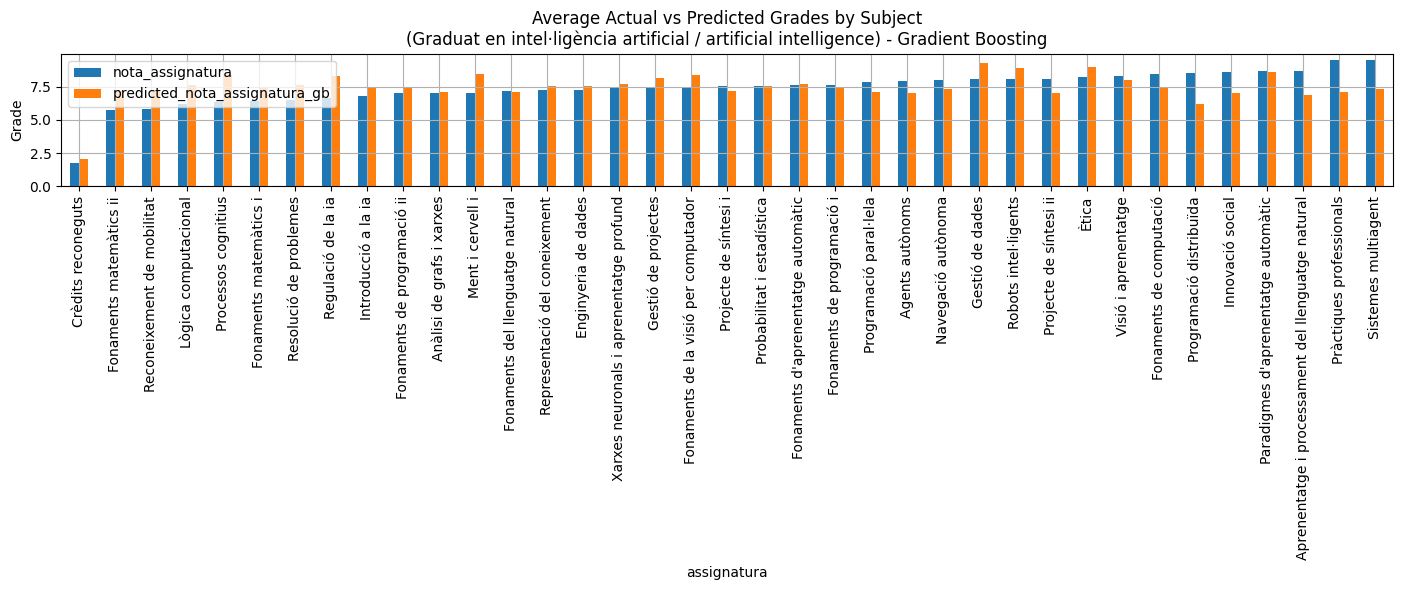

In [21]:

plot_predicted_vs_actual(df_pred_target, "predicted_nota_assignatura_gb", "Gradient Boosting", unique_studies)
plot_residuals(df_pred_target, "predicted_nota_assignatura_gb", "Gradient Boosting", unique_studies)
plot_barplot_avg_grades(df_pred_target, "predicted_nota_assignatura_gb", "Gradient Boosting", unique_studies)


## 5. Ensemble Trees

**Ensemble models** combine several different algorithms to make a single, stronger prediction. In this case, we use three tree-based models—Random Forest, Gradient Boosting, and Decision Tree—working together through a method called **VotingRegressor**.

We use an ensemble here because predicting student grades is complex, and different models may capture different patterns. By combining them, we reduce the chance of large errors and get more accurate and balanced predictions than using just one model alone.

In [22]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib

# Define ensemble with reduced complexity for speed
ensemble_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', VotingRegressor(estimators=[
        ('rf', RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
        ('dt', DecisionTreeRegressor(max_depth=8, random_state=42))
    ]))
])

# Fit ensemble
ensemble_pipeline.fit(X_train, y_train)

# Predict on 2023/24
df_pred_target['predicted_nota_assignatura_ensemble'] = ensemble_pipeline.predict(X_pred)

joblib.dump(ensemble_pipeline, 'ensemble_model.pkl')


['ensemble_model.pkl']

In [23]:
evaluate_model("Ensemble Trees", ensemble_pipeline, X_pred, y_pred, df_pred_target, "predicted_nota_assignatura_ensemble")

Ensemble Trees - R² Score on 2023/24 prediction set: 0.40
Ensemble Trees - Mean Absolute Error (MAE): 1.44
Ensemble Trees - Mean Squared Error for 2023/24 predictions: 3.92
Ensemble Trees - Root Mean Squared Error (RMSE): 1.98


---
The Ensemble Trees model slightly outperformed Gradient Boosting, with an **R² score of 0.37**, meaning it explains 37% of the variance in student grades. The **MAE of 1.55** and **RMSE of 2.07** indicate modest improvements in prediction accuracy, with errors averaging just over 1.5 points. 


---

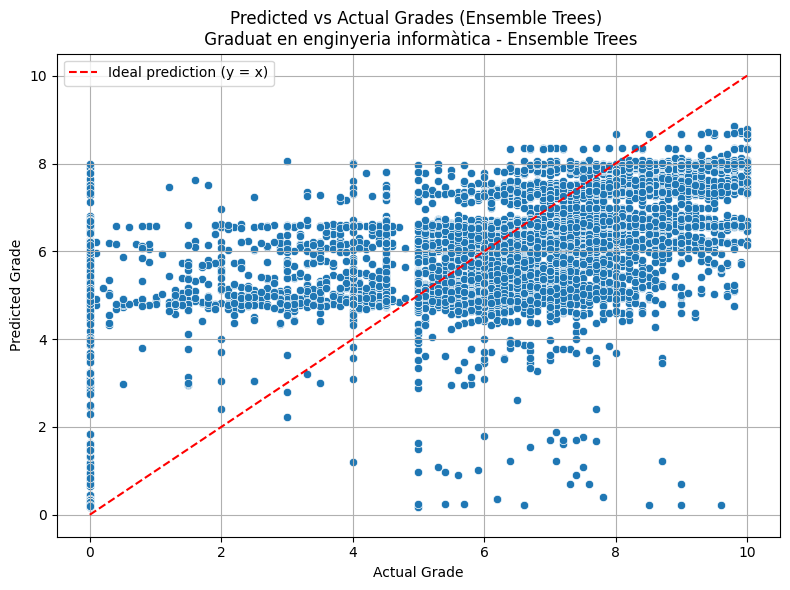

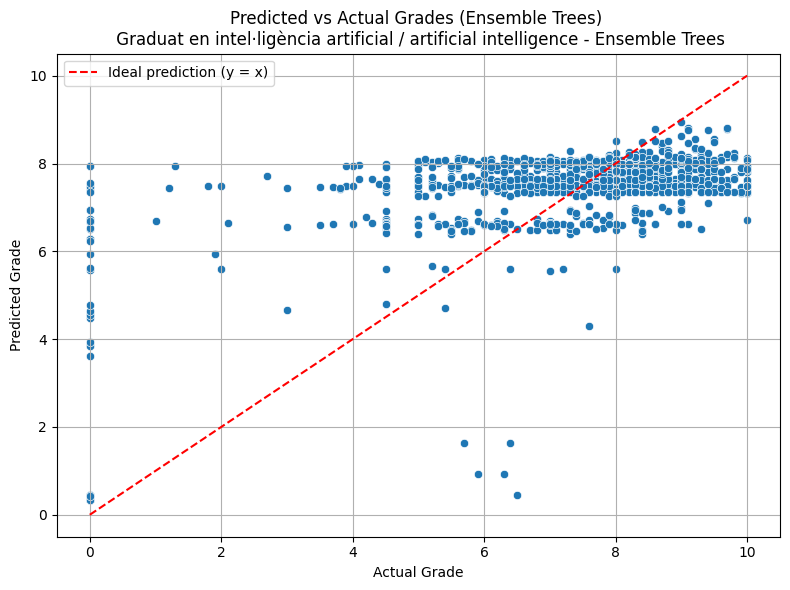

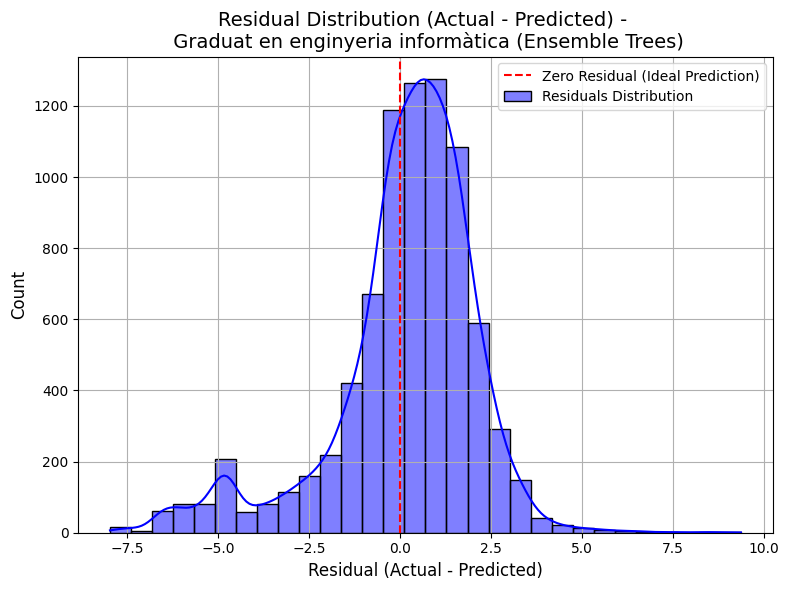

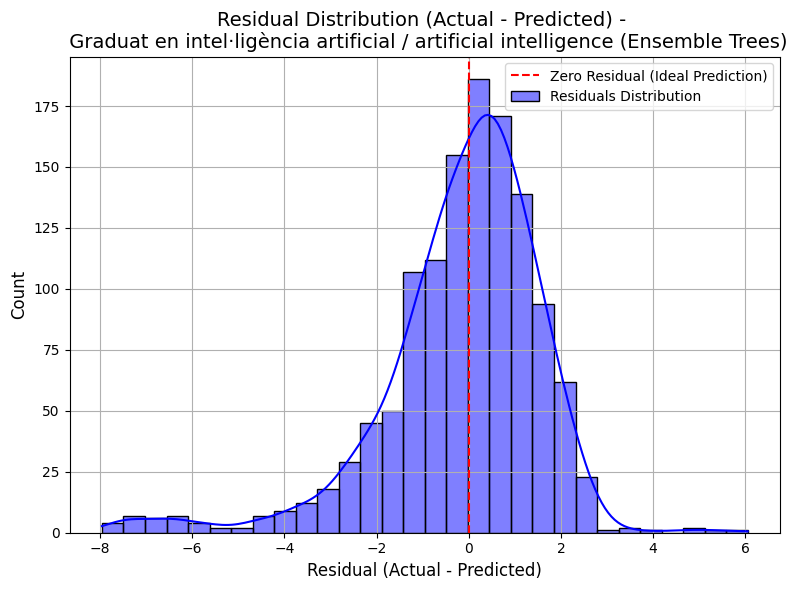

<Figure size 1200x600 with 0 Axes>

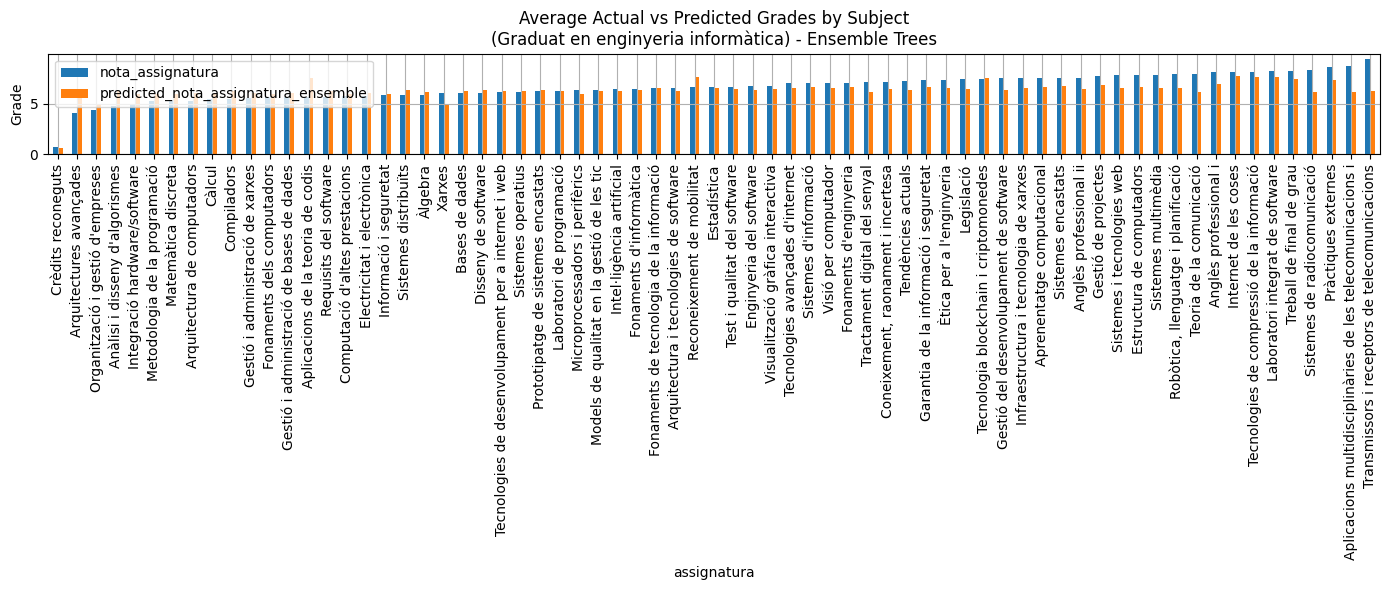

<Figure size 1200x600 with 0 Axes>

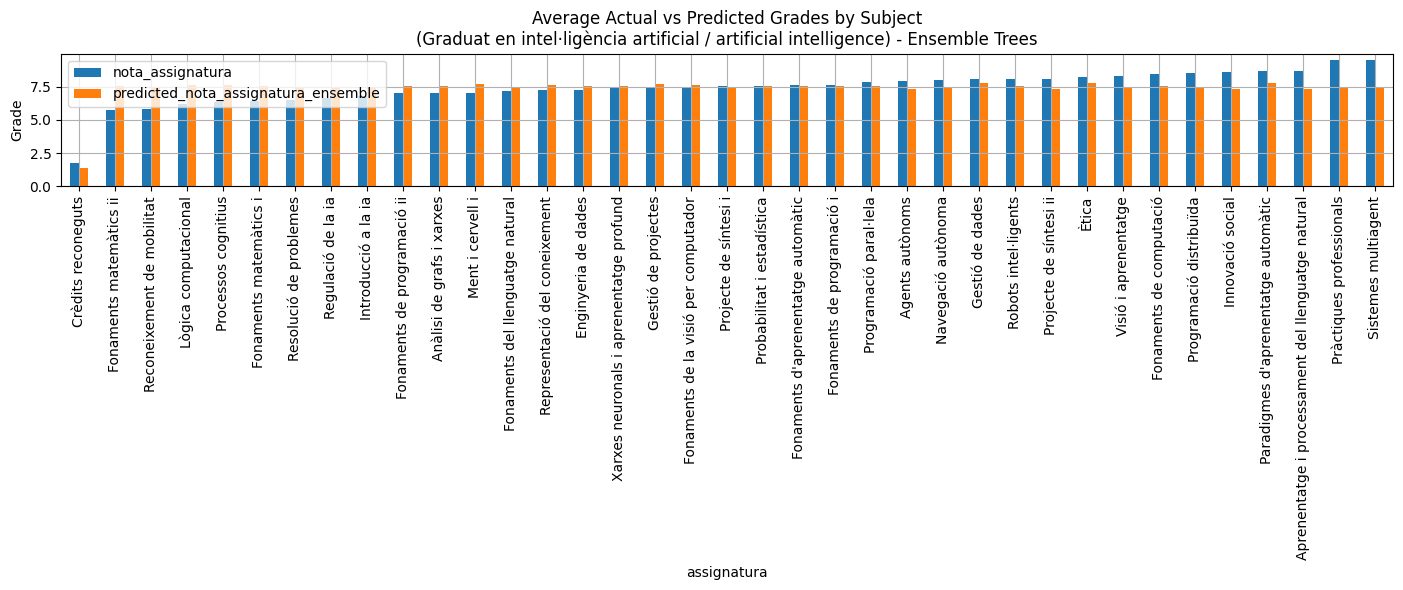

In [24]:
plot_predicted_vs_actual(df_pred_target, "predicted_nota_assignatura_ensemble", "Ensemble Trees", unique_studies)
plot_residuals(df_pred_target, "predicted_nota_assignatura_ensemble", "Ensemble Trees", unique_studies)
plot_barplot_avg_grades(df_pred_target, "predicted_nota_assignatura_ensemble", "Ensemble Trees", unique_studies)

----------------------------------


# CONCLUSIONS

> This grouped bar chart visually compares the performance of all trained models across four key evaluation metrics:
> 
> - **R² Score**: Measures how well the model explains the variance in the target variable. Closer to 1 is better.
> 
> - **MAE (Mean Absolute Error)**: Average of absolute prediction errors. Lower is better.
> 
> - **MSE (Mean Squared Error)**: Average of squared prediction errors. Lower is better but sensitive to outliers.
> 
> - **RMSE (Root Mean Squared Error)**: Square root of MSE, interpretable in the same units as the target variable. Lower is better.
> 
> Each group on the x-axis represents a **model** (e.g., Linear Regression, Random Forest), and within each group, the bars represent the different evaluation metrics. This allows you to visually **compare strengths and weaknesses** of each model side-by-side and select the most appropriate one based on your performance priorities (e.g., lowest error or best R²).

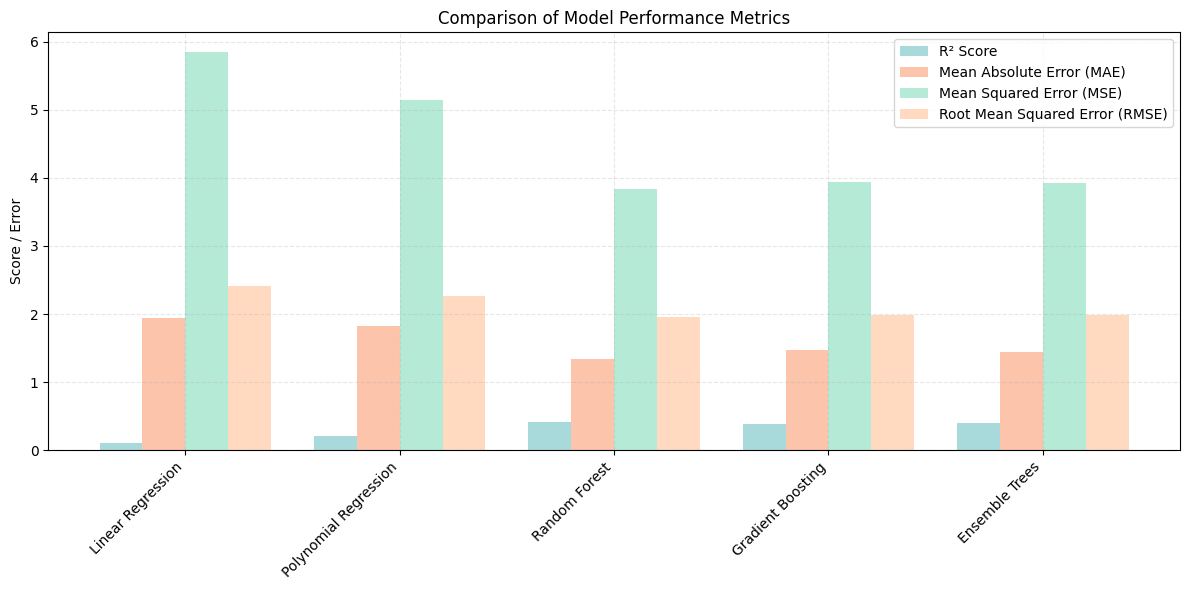

In [25]:
metrics = [
    "R² Score",
    "Mean Absolute Error (MAE)",
    "Mean Squared Error (MSE)",
    "Root Mean Squared Error (RMSE)"
]


models = list(allmodels_evaluation_results.keys())

# Extract values for each metric per model
metric_values = {
    metric: [allmodels_evaluation_results[model][metric] for model in models]
    for metric in metrics
}


x = range(len(models))       # x locations for each model group
width = 0.2                  # width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#A8DADC', '#FBC4AB', '#B5EAD7', '#FFDAC1']

for i, metric in enumerate(metrics):
    offset = (i - 1.5) * width  # distribute bars around the center
    ax.bar(
        [pos + offset for pos in x],
        metric_values[metric],
        width=width,
        label=metric,
        color=colors[i]
    )


ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_ylabel("Score / Error")
ax.set_title("Comparison of Model Performance Metrics")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


> Based on the plotted metrics, the Ensemble Trees model demonstrates superior overall performance. It achieves:
> 
> - The **highest R² score**, indicating the best fit to the data.
> 
> - The **lowest MAE, MSE, and RMSE**, reflecting minimal prediction errors across all evaluation types.
> 
> In contrast, **Linear Regression** and **Polynomial Regression** show the highest error rates, especially in MSE and RMSE. This suggests that these models struggle to capture complex, nonlinear relationships in the dataset. Linear models assume a straight-line relationship between features and the target, which likely oversimplifies the underlying structure of student performance. Even though Polynomial Regression introduces some curvature, it may still be too rigid or overfit certain patterns without generalizing well.
> 
> The **Ensemble Trees** model stands out because it combines the predictive strengths of multiple decision tree-based models—typically **Random Forest** and **Gradient Boosting**. This hybrid approach leverages:
> 
> - **Random Forest**'s ability to reduce variance by averaging many deep trees trained on bootstrapped data, improving generalization.
> 
> - **Gradient Boosting**'s strength in reducing bias by sequentially correcting errors from previous models.
> 
> By integrating both, Ensemble Trees **balance bias and variance more effectively**, capturing intricate feature interactions and nonlinearities while minimizing overfitting. This makes them exceptionally well-suited for tasks like grade prediction, where the relationships between features and outcomes are complex and multifactorial.



----------------------------------

## Model Exploration: Ensemble Trees
With ensemble trees we want to see that if we add more data provides better solutions, or we extract some background of the students provided better results.

#### First we extract data

In [26]:
X_train = df_train.drop(columns=['nota_assignatura'])
y_train = df_train['nota_assignatura']

X_pred = df_pred_target.drop(columns=['nota_assignatura'])
y_pred = df_pred_target['nota_assignatura'] 

ensemble_pipeline.fit(X_train, y_train)

### Predict on 2023/24
df_pred_target['predicted_nota_assignatura_ensemble'] = ensemble_pipeline.predict(X_pred)


evaluate_model("Ensemble Trees", ensemble_pipeline, X_pred, y_pred, df_pred_target, "predicted_nota_assignatura_ensemble")

In [27]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import combinations
allmodels_evaluation_results = {}

# All features to consider
all_features = [
    'estudi', 'curs_academic', 'id_anonim', 'sexe', 'assignatura',
    'codi_assignatura', 'via_acces_estudi', 'nota_d_acces',
    'dedicacio_de_l_estudiant', 'discapacitat', 'beca_concedida',
    'estudis_mare', 'estudis_pare', 'taxa_exit', 'abandonament'
]

y_train = df_train['nota_assignatura']
y_pred_real = df_pred_target['nota_assignatura']

def evaluate_model(model_name, model, X_pred, y_pred, df_pred_target, prediction_column):
    if not y_pred.isna().all():
        mse = mean_squared_error(y_pred, df_pred_target[prediction_column])
        r2 = model.score(X_pred, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_pred, df_pred_target[prediction_column])

        allmodels_evaluation_results[model_name] = {
            "R² Score": r2,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        }

        print(f"\n{model_name}")
        print(f"R²: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

for i in range(1, len(all_features) + 1):
    selected_features = all_features[:i]

    X_train_sub = df_train[selected_features]
    X_pred_sub = df_pred_target[selected_features]

    categorical_cols = X_train_sub.select_dtypes(include='object').columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    ensemble_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', VotingRegressor(estimators=[
            ('rf', RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42)),
            ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
            ('dt', DecisionTreeRegressor(max_depth=8, random_state=42))
        ]))
    ])

    ensemble_pipeline.fit(X_train_sub, y_train)

    df_pred_target[f'predicted_ensemble_{i}f'] = ensemble_pipeline.predict(X_pred_sub)

    model_name = f'Ensemble with {i} features: {selected_features}'
    evaluate_model(model_name, ensemble_pipeline, X_pred_sub, y_pred_real, df_pred_target, f'predicted_ensemble_{i}f')

# Results ordered by R² Score
sorted_results = sorted(allmodels_evaluation_results.items(), key=lambda x: x[1]['R² Score'], reverse=True)

print("\n Combinations ranking based on R²:")
for rank, (name, metrics) in enumerate(sorted_results, 1):
    print(f"{rank}. {name} → R²: {metrics['R² Score']:.4f}")


Ensemble with 1 features: ['estudi']
R²: -0.1735, MAE: 2.3619, MSE: 7.6179, RMSE: 2.7600

Ensemble with 2 features: ['estudi', 'curs_academic']
R²: 0.0028, MAE: 1.9775, MSE: 6.4731, RMSE: 2.5442

Ensemble with 3 features: ['estudi', 'curs_academic', 'id_anonim']
R²: 0.0125, MAE: 1.9485, MSE: 6.4106, RMSE: 2.5319

Ensemble with 4 features: ['estudi', 'curs_academic', 'id_anonim', 'sexe']
R²: 0.0129, MAE: 1.9482, MSE: 6.4077, RMSE: 2.5313

Ensemble with 5 features: ['estudi', 'curs_academic', 'id_anonim', 'sexe', 'assignatura']
R²: 0.2267, MAE: 1.6933, MSE: 5.0201, RMSE: 2.2405

Ensemble with 6 features: ['estudi', 'curs_academic', 'id_anonim', 'sexe', 'assignatura', 'codi_assignatura']
R²: 0.2311, MAE: 1.6803, MSE: 4.9915, RMSE: 2.2342

Ensemble with 7 features: ['estudi', 'curs_academic', 'id_anonim', 'sexe', 'assignatura', 'codi_assignatura', 'via_acces_estudi']
R²: 0.2337, MAE: 1.6775, MSE: 4.9742, RMSE: 2.2303

Ensemble with 8 features: ['estudi', 'curs_academic', 'id_anonim', 'sex

In [28]:
import random
import itertools
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from tqdm import tqdm

all_features = [
    'estudi', 'curs_academic', 'id_anonim', 'sexe', 'assignatura',
    'codi_assignatura', 'via_acces_estudi', 'nota_d_acces',
    'dedicacio_de_l_estudiant', 'discapacitat', 'beca_concedida',
    'estudis_mare', 'estudis_pare', 'taxa_exit', 'abandonament'
]
n_combinations = 100  
min_features = 6
max_features = 14

results = []

# ---------------------------------------
# LOOP ABOVE RANDOM COMBINATIONS
# ---------------------------------------
for _ in tqdm(range(n_combinations)):
    subset_size = random.randint(min_features, max_features)
    selected_features = sorted(random.sample(all_features, subset_size))

    # Subset de data
    X_train_sub = X_train[selected_features]
    X_pred_sub = X_pred[selected_features]

    # Pipeline 
    categorical_cols = X_train_sub.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X_train_sub.select_dtypes(include=['int64', 'float64']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

    ensemble_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', VotingRegressor(estimators=[
            ('rf', RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42)),
            ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
            ('dt', DecisionTreeRegressor(max_depth=8, random_state=42))
        ]))
    ])

    try:
        ensemble_pipeline.fit(X_train_sub, y_train)
        r2 = ensemble_pipeline.score(X_pred_sub, y_pred)
        results.append((r2, selected_features))
    except Exception as e:
        print(f"⚠️ Error {selected_features}: {e}")
        continue

# ---------------------------------------
# SHOW TOP RESULTS
# ---------------------------------------
results_sorted = sorted(results, key=lambda x: x[0], reverse=True)

print("\n TOP 10 combinations par R²:")
for rank, (r2, feats) in enumerate(results_sorted[:10], 1):
    print(f"{rank}. R²={r2:.4f} | Features: {feats}")

100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


 TOP 10 combinations par R²:
1. R²=0.4307 | Features: ['beca_concedida', 'codi_assignatura', 'curs_academic', 'dedicacio_de_l_estudiant', 'discapacitat', 'estudi', 'estudis_mare', 'nota_d_acces', 'sexe', 'taxa_exit']
2. R²=0.4208 | Features: ['assignatura', 'beca_concedida', 'curs_academic', 'dedicacio_de_l_estudiant', 'discapacitat', 'estudi', 'estudis_mare', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'taxa_exit', 'via_acces_estudi']
3. R²=0.4208 | Features: ['assignatura', 'beca_concedida', 'curs_academic', 'dedicacio_de_l_estudiant', 'discapacitat', 'estudi', 'estudis_mare', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'taxa_exit', 'via_acces_estudi']
4. R²=0.4207 | Features: ['assignatura', 'curs_academic', 'dedicacio_de_l_estudiant', 'estudi', 'estudis_mare', 'id_anonim', 'nota_d_acces', 'sexe', 'taxa_exit', 'via_acces_estudi']
5. R²=0.4025 | Features: ['assignatura', 'beca_concedida', 'codi_assignatura', 'curs_academic', 'dedicacio_de_l_estudiant', 'discapacitat', 'estudis_mar

#### Now, we will train the model with different featues

In [29]:
# ====================
# Evaluation Function
# # ====================
def evaluate_model(name, model, X, y_true, df_pred, pred_col):
    r2 = r2_score(y_true, df_pred[pred_col])
    rmse = mean_squared_error(y_true, df_pred[pred_col]) ** 0.5
    print(f"{name}\n → R²: {r2:.4f} | RMSE: {rmse:.4f}\n")

# ====================
# Features to evaluated (the best ones)
# ====================
feature_sets = [
    ['assignatura', 'beca_concedida', 'codi_assignatura', 'curs_academic', 'dedicacio_de_l_estudiant', 'discapacitat', 'estudi', 'estudis_mare', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'taxa_exit', 'via_acces_estudi'],
    ['assignatura', 'beca_concedida', 'codi_assignatura', 'curs_academic', 'dedicacio_de_l_estudiant', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'taxa_exit', 'via_acces_estudi'],
    ['assignatura', 'beca_concedida', 'codi_assignatura', 'curs_academic', 'dedicacio_de_l_estudiant', 'discapacitat', 'estudi', 'estudis_mare', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'sexe', 'taxa_exit'],
    ['assignatura', 'codi_assignatura', 'curs_academic', 'estudi', 'estudis_mare', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'sexe', 'taxa_exit', 'via_acces_estudi'],
    ['beca_concedida', 'codi_assignatura', 'curs_academic', 'discapacitat', 'estudis_mare', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'sexe', 'taxa_exit'],
    ['assignatura', 'beca_concedida', 'curs_academic', 'estudis_pare', 'nota_d_acces', 'taxa_exit', 'via_acces_estudi']
]

# ====================
# Training
# # ====================
for i, selected_features in enumerate(feature_sets, 1):
    X_train_sub = df_train[selected_features]
    X_pred_sub = df_pred_target[selected_features]

    categorical_cols = X_train_sub.select_dtypes(include='object').columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    ensemble_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', VotingRegressor(estimators=[
            ('rf', RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42)),
            ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
            ('dt', DecisionTreeRegressor(max_depth=8, random_state=42))
        ]))
    ])

    ensemble_pipeline.fit(X_train_sub, y_train)

    pred_col = f'predicted_ensemble_{i}f'
    df_pred_target[pred_col] = ensemble_pipeline.predict(X_pred_sub)

    model_name = f'Ensemble with {len(selected_features)} features: {selected_features}'
    evaluate_model(model_name, ensemble_pipeline, X_pred_sub, y_pred_real, df_pred_target, pred_col)


Ensemble with 13 features: ['assignatura', 'beca_concedida', 'codi_assignatura', 'curs_academic', 'dedicacio_de_l_estudiant', 'discapacitat', 'estudi', 'estudis_mare', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'taxa_exit', 'via_acces_estudi']
 → R²: 0.4291 | RMSE: 1.9252

Ensemble with 10 features: ['assignatura', 'beca_concedida', 'codi_assignatura', 'curs_academic', 'dedicacio_de_l_estudiant', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'taxa_exit', 'via_acces_estudi']
 → R²: 0.4275 | RMSE: 1.9278

Ensemble with 13 features: ['assignatura', 'beca_concedida', 'codi_assignatura', 'curs_academic', 'dedicacio_de_l_estudiant', 'discapacitat', 'estudi', 'estudis_mare', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'sexe', 'taxa_exit']
 → R²: 0.4267 | RMSE: 1.9292

Ensemble with 11 features: ['assignatura', 'codi_assignatura', 'curs_academic', 'estudi', 'estudis_mare', 'estudis_pare', 'id_anonim', 'nota_d_acces', 'sexe', 'taxa_exit', 'via_acces_estudi']
 → R²: 0.4254 | RMSE: 1.9314

Ense

Ensemble 1f → R²: 0.4291 | RMSE: 3.7062
Ensemble 2f → R²: 0.4275 | RMSE: 3.7166
Ensemble 3f → R²: 0.4267 | RMSE: 3.7216
Ensemble 4f → R²: 0.4254 | RMSE: 3.7303
Ensemble 5f → R²: 0.4228 | RMSE: 3.7468
Ensemble 6f → R²: 0.4219 | RMSE: 3.7526


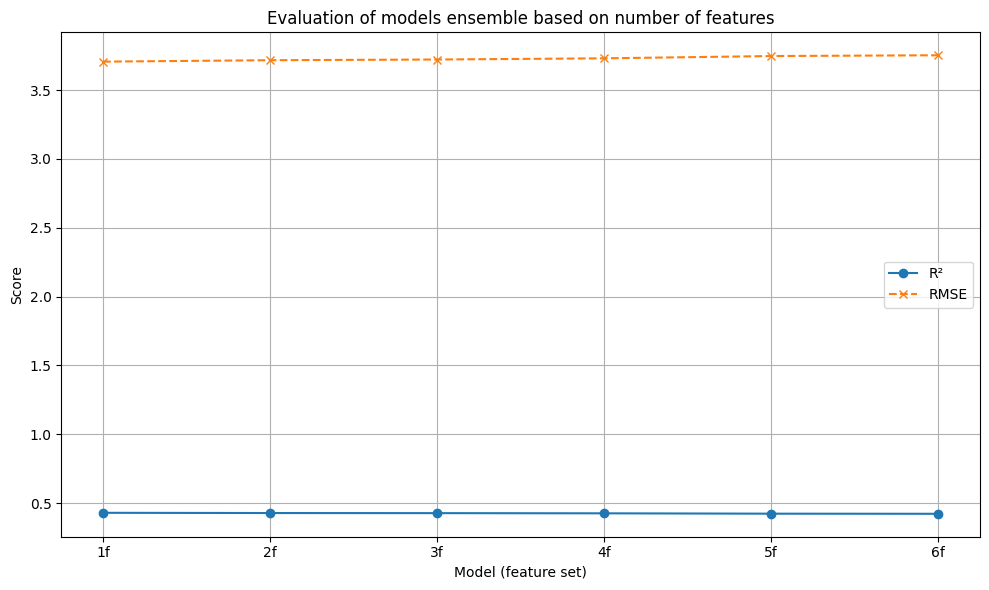

In [30]:
import matplotlib.pyplot as plt

#keep results
r2_scores = []
rmse_scores = []
labels = []

for i, selected_features in enumerate(feature_sets, 1):
    X_train_sub = df_train[selected_features]
    X_pred_sub = df_pred_target[selected_features]

    categorical_cols = X_train_sub.select_dtypes(include='object').columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    ensemble_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', VotingRegressor(estimators=[
            ('rf', RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42)),
            ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
            ('dt', DecisionTreeRegressor(max_depth=8, random_state=42))
        ]))
    ])

    ensemble_pipeline.fit(X_train_sub, y_train)

    pred_col = f'predicted_ensemble_{i}f'
    df_pred_target[pred_col] = ensemble_pipeline.predict(X_pred_sub)

    r2 = r2_score(y_pred_real, df_pred_target[pred_col])
    rmse = mean_squared_error(y_pred_real, df_pred_target[pred_col])
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    labels.append(f'{i}f')

    print(f'Ensemble {i}f → R²: {r2:.4f} | RMSE: {rmse:.4f}')

# ====================
# Visualization
# ====================
plt.figure(figsize=(10, 6))
plt.plot(labels, r2_scores, marker='o', label='R²')
plt.plot(labels, rmse_scores, marker='x', linestyle='--', label='RMSE')
plt.title('Evaluation of models ensemble based on number of features')
plt.xlabel('Model (feature set)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


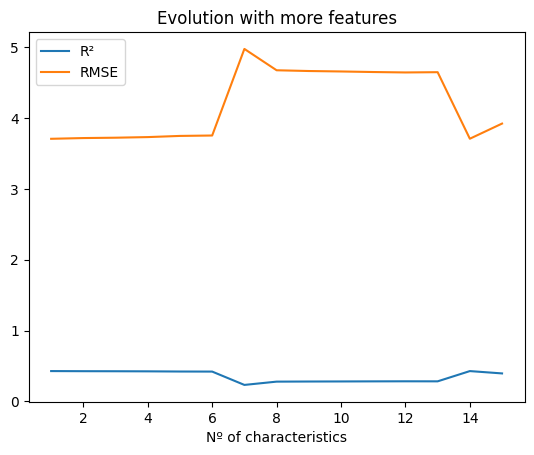

In [31]:
y_true = df_pred_target['nota_assignatura']

r2s = []
rmses = []
for i in range(1, 16):
    col = f'predicted_ensemble_{i}f'
    r2s.append(r2_score(y_true, df_pred_target[col]))
    rmses.append(mean_squared_error(y_true, df_pred_target[col]))

plt.plot(range(1, 16), r2s, label='R²')
plt.plot(range(1, 16), rmses, label='RMSE')
plt.xlabel('Nº of characteristics')
plt.title('Evolution with more features')
plt.legend()
plt.show()